# Exploring Mental Health Data
Duong Tan Loc, Nguyen Viet Hung, Nguyen Viet Nguyen

**Model Training, Model Evaluation, Fine-tuning**

Load data

In [1]:
import pandas as pd

In [ ]:
df1 = pd.read_csv("data/data1_feature_eng.csv")

In [3]:
df1.head()

,Age,Have you ever had suicidal thoughts ?,Aca/Work Pressure,Financial Stress,Aca/Work Satisfaction,Working Professional or Student,CGPA,Work/Study Hours,Dietary Habits,Profession,Sleep Duration,Depression
0,49.0,No,5.0,2.0,2.0,Working Professional,NaN,1.0,Healthy,Chef,8.5,0
1,26.0,Yes,4.0,3.0,3.0,Working Professional,NaN,7.0,Unhealthy,Teacher,4.5,1
2,33.0,Yes,5.0,1.0,2.0,Student,8.97,3.0,Healthy,missing,5.5,1
3,22.0,Yes,5.0,1.0,1.0,Working Professional,NaN,10.0,Moderate,Teacher,4.5,1
4,30.0,Yes,1.0,4.0,1.0,Working Professional,NaN,9.0,Unhealthy,Business Analyst,5.5,0


In [4]:
df1.isnull().sum()

Age                                           0
Have you ever had suicidal thoughts ?         0
Aca/Work Pressure                             0
Financial Stress                              0
Aca/Work Satisfaction                         0
Working Professional or Student               0
CGPA                                     112802
Work/Study Hours                              0
Dietary Habits                                0
Profession                                    0
Sleep Duration                                0
Depression                                    0
dtype: int64

## 1. Choose metrics

Dựa trên dataset, ở bước EDA ta thấy rằng tỉ lệ 2 nhãn ở target bị lệch mạnh:
- No Depression chiếm ~80%
- Depression chiếm ~20%

Vì thế, việc chọn metric là accuracy là không phù hợp với bộ dữ liệu này (mặc dù cuộc thi Kaggle chấm bằng Accuracy).


Các metric khác như: Precision, Recall, F1-score, ROC-AUC


Nhóm chọn Recall làm metric chính: 
$$Recall = \frac{\text{Số người bị trầm cảm được phát hiện đúng}}{\text{Tổng số người thật sự bị trầm cảm}}$$

Nếu mô hình có Recall cao, nghĩa là nó có khả năng phát hiện phần lớn người thật sự bị trầm cảm, tránh để họ bị bỏ qua — điều rất quan trọng trong y tế và sức khỏe tâm thần.

Bên cạnh đó, F1-score cũng được sử dụng làm metric phụ, giúp kiểm soát sự cân bằng giữa Precision và Recall

## 2. Model Training

Vì bộ dữ liệu chứ nhiều cột dạng category (không được encoding vì chứa rất nhiều nhãn) nên nhóm chọn model có thể tự xử lí dữ liệu dạng Categorical.

Chọn model:
1. CatBoost
2. LightGBM 

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X, y = df1.drop(columns=["Depression"]), df1["Depression"]

In [9]:
X = X.astype({col: 'category' for col in X.select_dtypes(include='object').columns})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

In [12]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Catboost

Huấn luyện mô hình bằng Catboost

In [14]:
cat_feas= X_train.select_dtypes(include='category').columns.tolist()

In [15]:
cat_model = CatBoostClassifier(cat_features=X_train.select_dtypes(include='category').columns.tolist(), verbose=0)
cat_model.fit(X_train, y_train)

# LightGBM

Huấn luyện mô hình bằng LightGBM

In [17]:
light_model = LGBMClassifier()
light_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20413, number of negative: 92147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181352 -> initscore=-1.507213
[LightGBM] [Info] Start training from score -1.507213


LGBMClassifier()

## 3. Model Evaluation

Đánh giá mô hình trên metrics đã chọn.
Nếu mô hình performance quá thấp so với những cái khác thì cân nhắc bỏ.


Đánh giá Catboost

In [18]:
y_pred_cat = cat_model.predict(X_test)

In [19]:
accuracy_cat=accuracy_score(y_test, y_pred_cat)
f1_cat=f1_score(y_test, y_pred_cat, average='macro')
recall_cat=recall_score(y_test, y_pred_cat)
precision_cat=precision_score(y_test, y_pred_cat)


print(" Đánh giá mô hình:")
print(f" Accuracy: {accuracy_cat:.10f}")
print(f" Recall: {recall_cat:.10f}")
print(f" F1-Score: {f1_cat:.10f}")
print(f" Precision: {precision_cat:.10f}")


 Đánh giá mô hình:
 Accuracy: 0.9393390192
 Recall: 0.8230500582
 F1-Score: 0.8977311135
 Precision: 0.8421679571


AUC-ROC = 0.9764


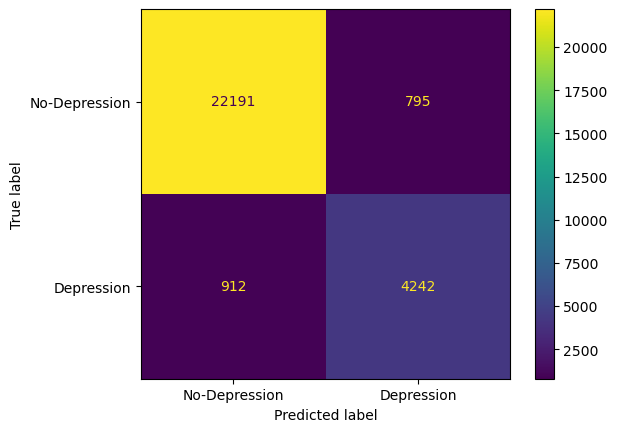

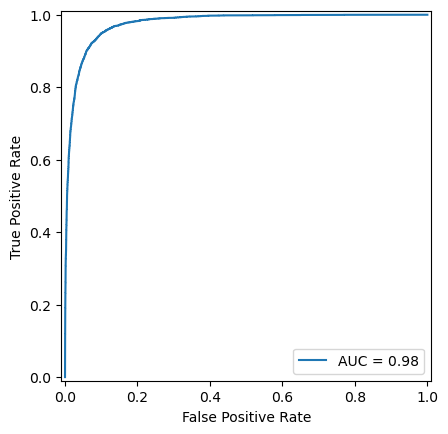

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

cm = confusion_matrix(y_test, y_pred_cat)
ConfusionMatrixDisplay(cm, display_labels=['No-Depression', 'Depression']).plot()

fpr, tpr, _ = roc_curve(y_test, cat_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
print(f"AUC-ROC = {roc_auc:.4f}")

# Nhận xét:
Với confusion matrix:
- Có 912 người bị trầm cảm nhưng bị dự đoán nhầm là không trầm cảm (False Negative). Điều này đặc biệt quan trọng nếu ứng dụng trong y tế, vì bỏ sót trầm cảm có thể gây hậu quả nghiêm trọng.

- Có 795 trường hợp không trầm cảm nhưng bị dự đoán là trầm cảm (False Positive), tuy ít hơn, nhưng vẫn cần lưu ý vì có thể gây lo lắng hoặc điều trị không cần thiết.

Với biểu đồ ROC, AUC = 0.98 cho thấy mô hình có khả năng phân biệt giữa người bị trầm cảm và không bị trầm cảm với độ chính xác phân biệt lên đến 98%

Recall = 0.82 => 82% số người thực sự bị trầm cảm (trong toàn bộ những người thực sự mắc trầm cảm) được model phát hiện đúng, tuy vẫn bỏ sót 18% nhưng kết hợp với kết quả precision = 0.84 và F1-score ~ 0.90 thì chứng tỏ mô hình hoạt động khá tốt, ổn định, có sự cân bằng giữa recall và precision và đáng tin cậy.

Từ đó mô hình giúp ít bỏ sót người cần giúp đỡ (recall cao) và ít gây hoang mang cho người không mắc (precision cao).

Đánh giá LightGBM

In [21]:
y_pred_light = light_model.predict(X_test)

In [22]:
accuracy_light=accuracy_score(y_test, y_pred_light)
f1_light=f1_score(y_test, y_pred_light, average='macro')
recall_light=recall_score(y_test, y_pred_light)
precision_light=precision_score(y_test, y_pred_light)


print(" Đánh giá mô hình:")
print(f" Accuracy: {accuracy_light:.10f}")
print(f" Recall: {recall_light:.10f}")
print(f" F1-Score: {f1_light:.10f}")
print(f" Precision: {precision_light:.10f}")


 Đánh giá mô hình:
 Accuracy: 0.9383084577
 Recall: 0.8195576251
 F1-Score: 0.8959379967
 Precision: 0.8397614314


AUC-ROC = 0.9761


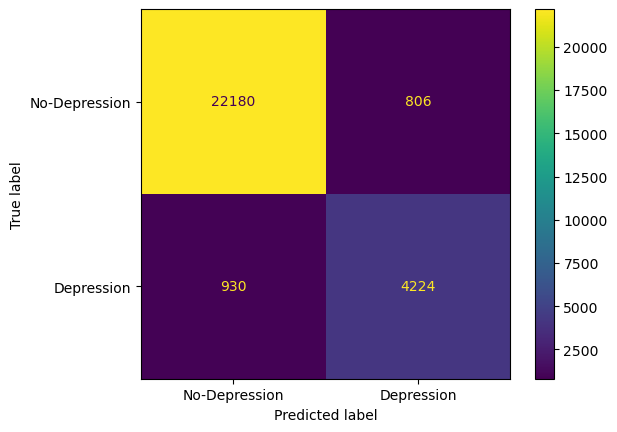

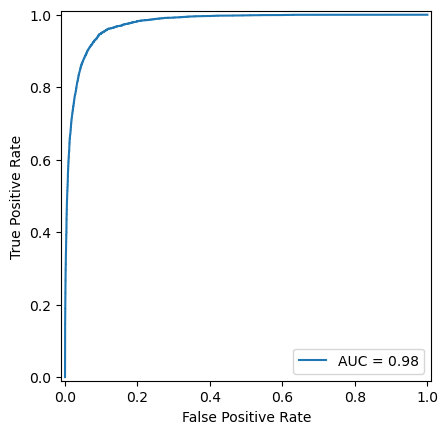

In [24]:

cm = confusion_matrix(y_test, y_pred_light)
ConfusionMatrixDisplay(cm, display_labels=['No-Depression', 'Depression']).plot()

fpr, tpr, _ = roc_curve(y_test, light_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
print(f"AUC-ROC = {roc_auc:.4f}")

# Nhận xét:
Với confusion matrix:
- Có 930 người bị trầm cảm nhưng bị dự đoán nhầm là không trầm cảm (False Negative).

- Có 806 trường hợp không trầm cảm nhưng bị dự đoán là trầm cảm (False Positive).

Với biểu đồ ROC: AUC = 0.98 nghĩa là mô hình có khả năng phân biệt giữa người bị trầm cảm và không bị trầm cảm lên đến 98%.

So với model Catboost, các metric của LightGBM tuy cho kết quả thấp hơn một chút nhưng cũng không chênh lệch quá nhiều. Vẫn đảm bảo rằng mô hình hoạt động khá tốt, ổn định, có sự cân bằng giữa recall và precision và đáng tin cậy

Thế nhưng thời gian huấn luyện của LightGBM nhanh hơn Catboost khá nhiều và đáng để cân nhắc khi chọn mô hình.

# Nhận xét chung: 
- Hai mô hình có hiệu suất rất sát nhau.

- LightGBM hơi tệ hơn một chút (số FN nhiều hơn 18, và FP nhiều hơn 11).

## 4. Model Fine-tuning

GridSearch

In [25]:
import matplotlib.pyplot as plt

Catboost

In [26]:
grid_cat = {
   'iterations': [300, 500, 700],           
    'learning_rate': [0.1,0.05],     
    'depth': [4, 6, 8],                      
    'l2_leaf_reg': [1, 5, 10], 
}

In [27]:
train_pool = Pool(X_train, y_train, cat_features=cat_feas)

In [28]:
model_cat = CatBoostClassifier(task_type="CPU", devices="0", loss_function='Logloss', eval_metric='Recall', verbose=0)

In [29]:
model_cat.grid_search(grid_cat, train_pool)


bestTest = 0.8144707895
bestIteration = 291

0:	loss: 0.8144708	best: 0.8144708 (0)	total: 10.6s	remaining: 9m 20s

bestTest = 0.8142263505
bestIteration = 293

1:	loss: 0.8142264	best: 0.8144708 (0)	total: 21.3s	remaining: 9m 14s

bestTest = 0.8144707895
bestIteration = 104

2:	loss: 0.8144708	best: 0.8144708 (0)	total: 32.7s	remaining: 9m 16s

bestTest = 0.8125152774
bestIteration = 270

3:	loss: 0.8125153	best: 0.8144708 (0)	total: 43.5s	remaining: 9m 3s

bestTest = 0.8149596676
bestIteration = 297

4:	loss: 0.8149597	best: 0.8149597 (4)	total: 54.6s	remaining: 8m 55s

bestTest = 0.8149596676
bestIteration = 291

5:	loss: 0.8149597	best: 0.8149597 (4)	total: 1m 4s	remaining: 8m 38s

bestTest = 0.8154485456
bestIteration = 318

6:	loss: 0.8154485	best: 0.8154485 (6)	total: 1m 23s	remaining: 9m 18s

bestTest = 0.8154485456
bestIteration = 354

7:	loss: 0.8154485	best: 0.8154485 (6)	total: 1m 42s	remaining: 9m 49s

bestTest = 0.8174040577
bestIteration = 471

8:	loss: 0.8174041	best: 

{'params': {'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 5,
  'iterations': 700},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [30]:
model_cat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Recall',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 700,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 5,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderTy

In [31]:
best_catparams = model_cat.get_params()

In [32]:
final_catmodel = CatBoostClassifier(cat_features=X_train.select_dtypes(include='category').columns.tolist(),**best_catparams)

In [33]:
accuracy_cat=accuracy_score(y_test, y_pred_cat)
f1_cat=f1_score(y_test, y_pred_cat, average='macro')
recall_cat=recall_score(y_test, y_pred_cat)
precision_cat=precision_score(y_test, y_pred_cat)


print(" Đánh giá mô hình trước khi tuning:")
print(f" Accuracy: {accuracy_cat:.10f}")
print(f" Recall: {recall_cat:.10f}")
print(f" F1-Score: {f1_cat:.10f}")
print(f" Precision: {precision_cat:.10f}")


 Đánh giá mô hình trước khi tuning:
 Accuracy: 0.9393390192
 Recall: 0.8230500582
 F1-Score: 0.8977311135
 Precision: 0.8421679571


In [34]:
final_catmodel.fit(X_train,y_train)

In [35]:
y_pred_cat_after = final_catmodel.predict(X_test)

In [36]:
accuracy_cat_after=accuracy_score(y_test, y_pred_cat_after)
f1_cat_after=f1_score(y_test, y_pred_cat_after, average='macro')
recall_cat_after=recall_score(y_test, y_pred_cat_after)
precision_cat_after=precision_score(y_test, y_pred_cat_after)


print(" Đánh giá mô hình sau khi tuning:")
print(f" Accuracy: {accuracy_cat_after:.10f}")
print(f" Recall: {recall_cat_after:.10f}")
print(f" F1-Score: {f1_cat_after:.10f}")
print(f" Precision: {precision_cat_after:.10f}")


 Đánh giá mô hình sau khi tuning:
 Accuracy: 0.9386638237
 Recall: 0.8176173846
 F1-Score: 0.8962992420
 Precision: 0.8428000000


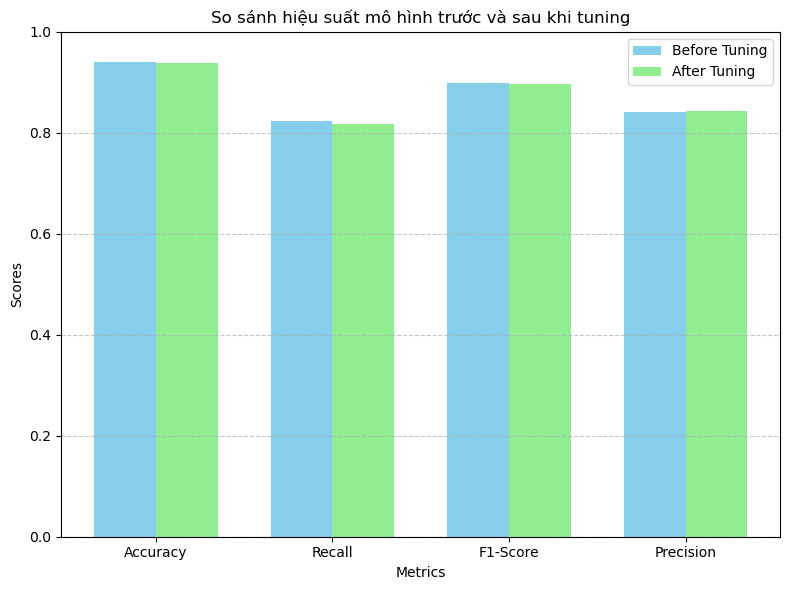

In [38]:
metrics = ['Accuracy', 'Recall', 'F1-Score','Precision']
before_scores = [accuracy_cat, recall_cat, f1_cat,precision_cat]
after_scores = [accuracy_cat_after, recall_cat_after, f1_cat_after,precision_cat_after]

x = range(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, before_scores, width=bar_width, label='Before Tuning', color='skyblue')
plt.bar([i + bar_width for i in x], after_scores, width=bar_width, label='After Tuning', color='lightgreen')

plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("So sánh hiệu suất mô hình trước và sau khi tuning")
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

AUC-ROC = 0.9768


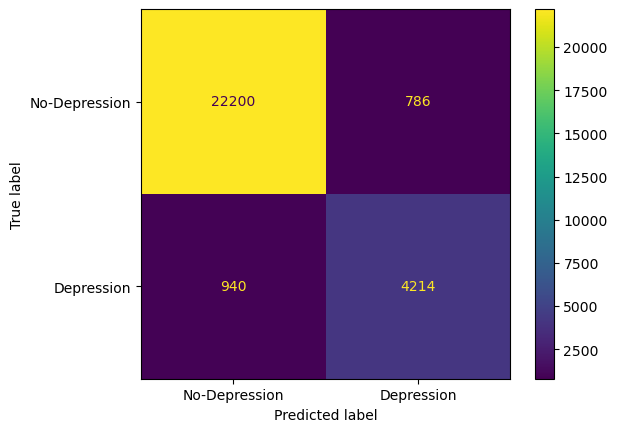

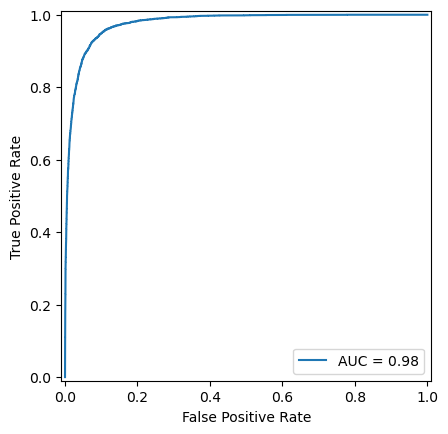

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

cm = confusion_matrix(y_test, y_pred_cat_after)
ConfusionMatrixDisplay(cm, display_labels=['No-Depression', 'Depression']).plot()

fpr, tpr, _ = roc_curve(y_test, final_catmodel.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
print(f"AUC-ROC = {roc_auc:.4f}")

# Nhận xét: Sau khi tuning, mô hình:

- Giảm nhẹ False Positive: ít chẩn đoán nhầm người khỏe là bị trầm cảm.

- Tăng nhẹ False Negative: bỏ sót thêm vài trường hợp trầm cảm.

- Giữ nguyên AUC: mô hình vẫn rất mạnh về tổng thể.

- Giảm nhẹ ở cả ba metric, điều này có thể do lưới tham số được đưa vào chưa phù hợp với bộ dữ liệu hơn là tham số mặc định khi huấn luyện mô hình.

LightGBM

In [40]:
grid_light = {
   'n_estimators': [300, 500, 800],                
    'max_depth': [6, 10, -1],                       
    'learning_rate': [0.01, 0.03, 0.05],            
    'subsample': [0.7, 0.8, 1.0],                  
    'colsample_bytree': [0.7, 0.8, 1.0], 
}

In [41]:
model_light = LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    verbose = -1
)

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
grid = GridSearchCV(
    estimator=model_light,
    param_grid=grid_light,
    scoring="recall",
    cv=3,
    n_jobs=-1
)

In [44]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LGBMClassifier(is_unbalance=True, objective='binary',
                                      verbose=-1),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [6, 10, -1],
                         'n_estimators': [300, 500, 800],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='recall')

In [45]:
best_lightparam = grid.best_params_

In [46]:
final_lightmodel = LGBMClassifier(**best_lightparam)

In [47]:
final_lightmodel.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, n_estimators=500,
               subsample=0.7)

In [48]:
y_pred_light = light_model.predict(X_test)

In [55]:
accuracy_light=accuracy_score(y_test, y_pred_light)
f1_light=f1_score(y_test, y_pred_light, average='macro')
recall_light=recall_score(y_test, y_pred_light)
precision_light=precision_score(y_test, y_pred_light)


print(" Đánh giá mô hình trước khi tuning:")
print(f" Accuracy: {accuracy_light:.10f}")
print(f" Recall: {recall_light:.10f}")
print(f" F1-Score: {f1_light:.10f}")
print(f" Precision: {precision_light:.10f}")


 Đánh giá mô hình trước khi tuning:
 Accuracy: 0.9383084577
 Recall: 0.8195576251
 F1-Score: 0.8959379967
 Precision: 0.8397614314


In [50]:
y_pred_light_after = final_lightmodel.predict(X_test)

In [56]:
accuracy_light_after=accuracy_score(y_test, y_pred_light_after)
f1_light_after=f1_score(y_test, y_pred_light_after, average='macro')
recall_light_after=recall_score(y_test, y_pred_light_after)
precision_light_after=precision_score(y_test, y_pred_light_after)


print(" Đánh giá mô hình sau khi tuning:")
print(f" Accuracy: {accuracy_light_after:.10f}")
print(f" Recall: {recall_light_after:.10f}")
print(f" F1-Score: {f1_light_after:.10f}")
print(f" Precision: {precision_light_after:.10f}")


 Đánh giá mô hình sau khi tuning:
 Accuracy: 0.9378820185
 Recall: 0.8143189756
 F1-Score: 0.8948805329
 Precision: 0.8414194066


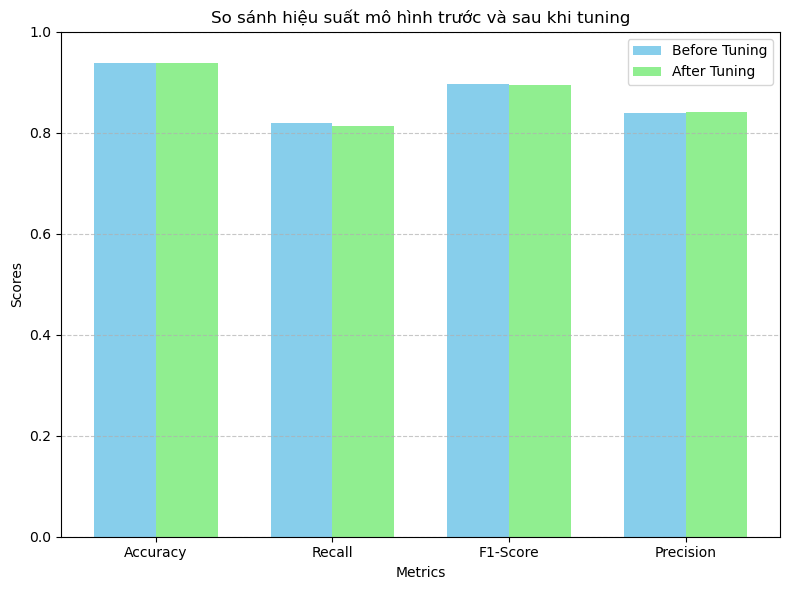

In [52]:
metrics = ['Accuracy', 'Recall', 'F1-Score','Precision']
before_scores = [accuracy_light, recall_light, f1_light,precision_light]
after_scores = [accuracy_light_after, recall_light_after, f1_light_after,precision_light_after]

x = range(len(metrics))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x, before_scores, width=bar_width, label='Before Tuning', color='skyblue')
plt.bar([i + bar_width for i in x], after_scores, width=bar_width, label='After Tuning', color='lightgreen')

plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("So sánh hiệu suất mô hình trước và sau khi tuning")
plt.xticks([i + bar_width / 2 for i in x], metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

AUC-ROC = 0.9761


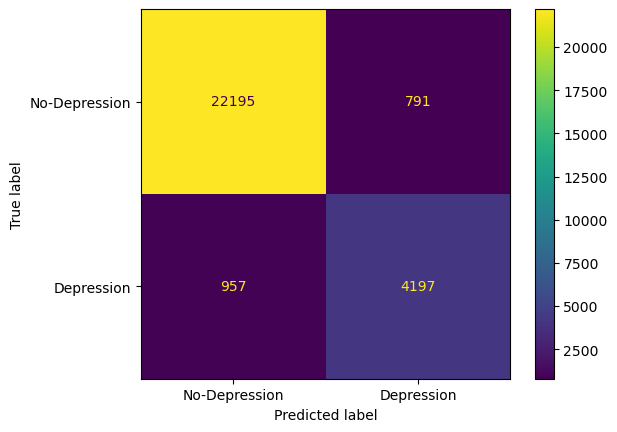

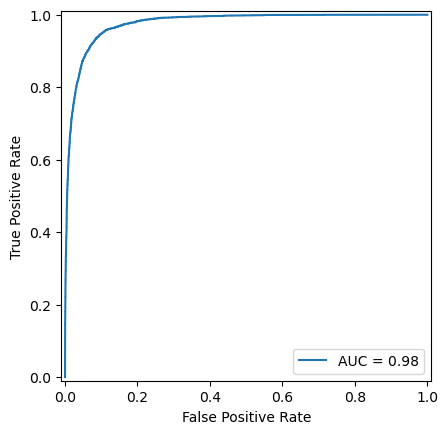

In [54]:

cm = confusion_matrix(y_test, y_pred_light_after)
ConfusionMatrixDisplay(cm, display_labels=['No-Depression', 'Depression']).plot()

fpr, tpr, _ = roc_curve(y_test, final_lightmodel.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
print(f"AUC-ROC = {roc_auc:.4f}")

# Nhận xét: Sau khi tuning mô hình
Cải thiện:
- Giảm False Positive: ít chẩn đoán sai người không bị trầm cảm là có.

- Tăng True Negative: tăng độ chính xác với người không bị trầm cảm.

Giảm nhẹ:
- Giảm True Positive: từ 4,224 xuống 4,197 → phát hiện đúng trầm cảm bị giảm nhẹ.

- Tăng False Negative: từ 930 lên 957 → bỏ sót thêm 27 người bị trầm cảm.

- Giảm nhẹ ở cả ba metric, điều này có thể do lưới tham số được đưa vào chưa phù hợp với bộ dữ liệu hơn là tham số mặc định khi huấn luyện mô hình.

# Nhận xét chung: cả 2 mô hình CatBoost và LightGBM sau khi tuning gần như tương đương, nhưng đều có kết quả thấp hơn lúc chưa tuning:

- CatBoost tốt hơn nhẹ ở TP và FN → phát hiện trầm cảm tốt hơn.

- LightGBM vẫn rất mạnh và có thể tối ưu thời gian huấn luyện tốt hơn CatBoost.

# Kết luận:
- Nếu mục tiêu là tối đa hóa khả năng phát hiện trầm cảm (giảm FN) thì CatBoost hiện đang là mô hình tốt nhất

- Nếu mục tiêu là tốc độ huấn luyện nhanh hơn, đánh đổi 1 ít hiệu quả thì LightGBM vẫn là lựa chọn rất tốt